In [1]:
%matplotlib notebook
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

# Othello SimPy Evaluations

Source code: https://github.com/l-nic/othello-sim

Simulator Info:
* Topology:
```
      Network
   /     |      \
 H1     H2 ...  Hn
```
* Two messages types: Map Messages & Reduce Messages
    * Map messages correspond to new boards that need to be further explored.
    * Once the desired number of moves have been explored, hosts will generate reduce messages and send them back up the game tree.
* The simulation completes once the host that sent out the initial map messages receives back all of the corresponding reduce messages.
* Each host has a single queue to buffer messages
* The network hashes map messages to hosts based on the msgID, and it forwards reduce messages based on the dstHostID in the message.
* The simulator models:
    * Network communication delay
    * Host service time to process map messages
    * Host queueing delay
* The simulator does *not* model:
    * Network queueing (i.e. assumes infinite network bandwidth on all links)
    * Service time to process reduce messages, which could be significant because the host needs to lookup state associated with the reduce message to know when to send the reduce message upstream
* Results match the analytical equation `T = D*s + (D-1)*(2d)` when the are enough hosts with perfect hashing (i.e. no queueing)

### Map Message Service Time CDF

Rather than using a static service time, each host will generate a sample from the following distribution to decide how long to service the map message before sending out new messages.

Creating plots ...


<IPython.core.display.Javascript object>


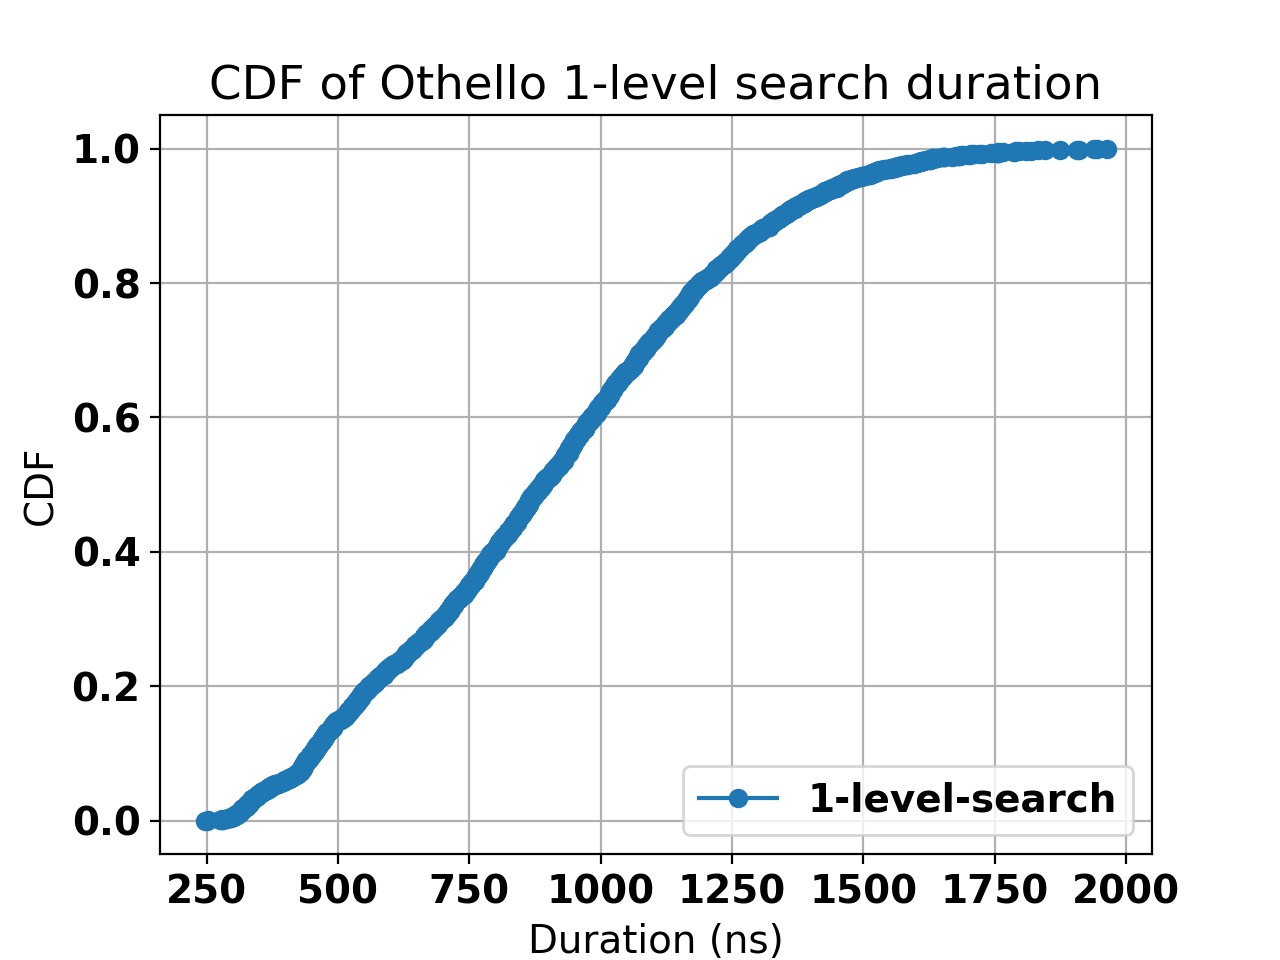

In [2]:
from plot_stats import plot_service_cdf

plot_service_cdf('dist/1-level-search.txt')

### Branching Factor CDF

Rather than using a static branching factor, each host will generate a sample from the following distirbution to decide how many Map messages it needs to send out. This distribution is computed from the [actual Othello implementation](https://github.com/l-nic/othello/tree/si/bit-board).

Creating plots ...


<IPython.core.display.Javascript object>


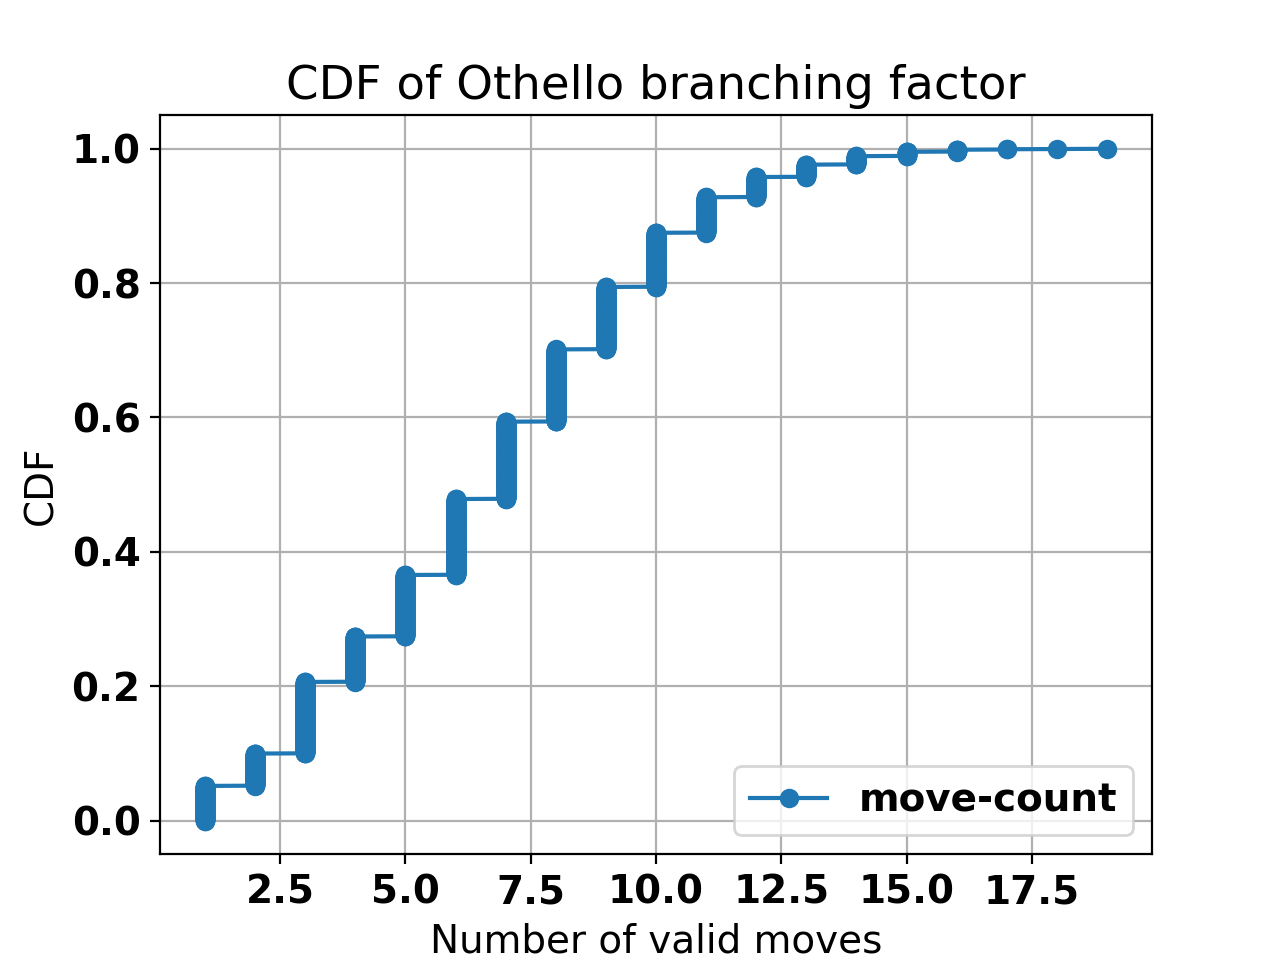

In [3]:
from plot_stats import plot_branch_cdf

plot_branch_cdf('dist/move-count.txt')

# Experiment 1

Experiment info:
* 1000 hosts
* Searching 8 levels deep into game tree
* Network communication delay: 2us vs 1us

Results:
* 2us communication delay => simulation completes in **780 us**  (runs in about 4.5 minutes real time)
* 1us communication delay => simulation completes in **314 us**  (runs in about 2 minutes real time)
* Single core implementation => **5.38 ms**
* So the distributed Othello implementation can potentially improve performance by about 20x

Notes:
* During the simulation, I sample all of the host queue sizes every 1us and compute the average (the first plot below). I also compute the CDF of all queue size samples over the duration of the simulation (the second plot below).
* It's interesting to note that reducing the network communication delay reduces the queue sizes, which in turn leads to faster completion time.

Creating plots ...


<IPython.core.display.Javascript object>


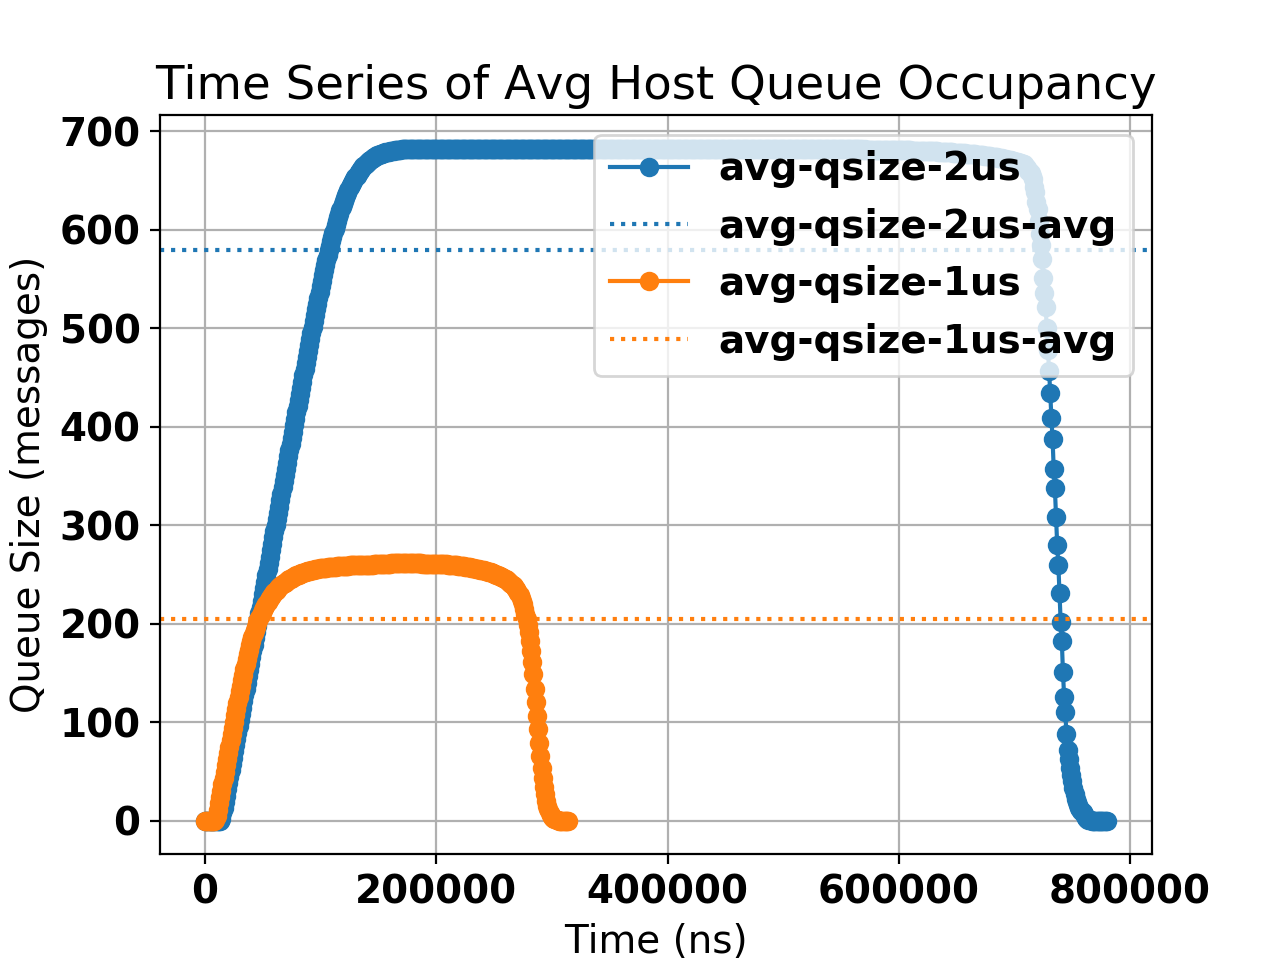

Creating plots ...


<IPython.core.display.Javascript object>


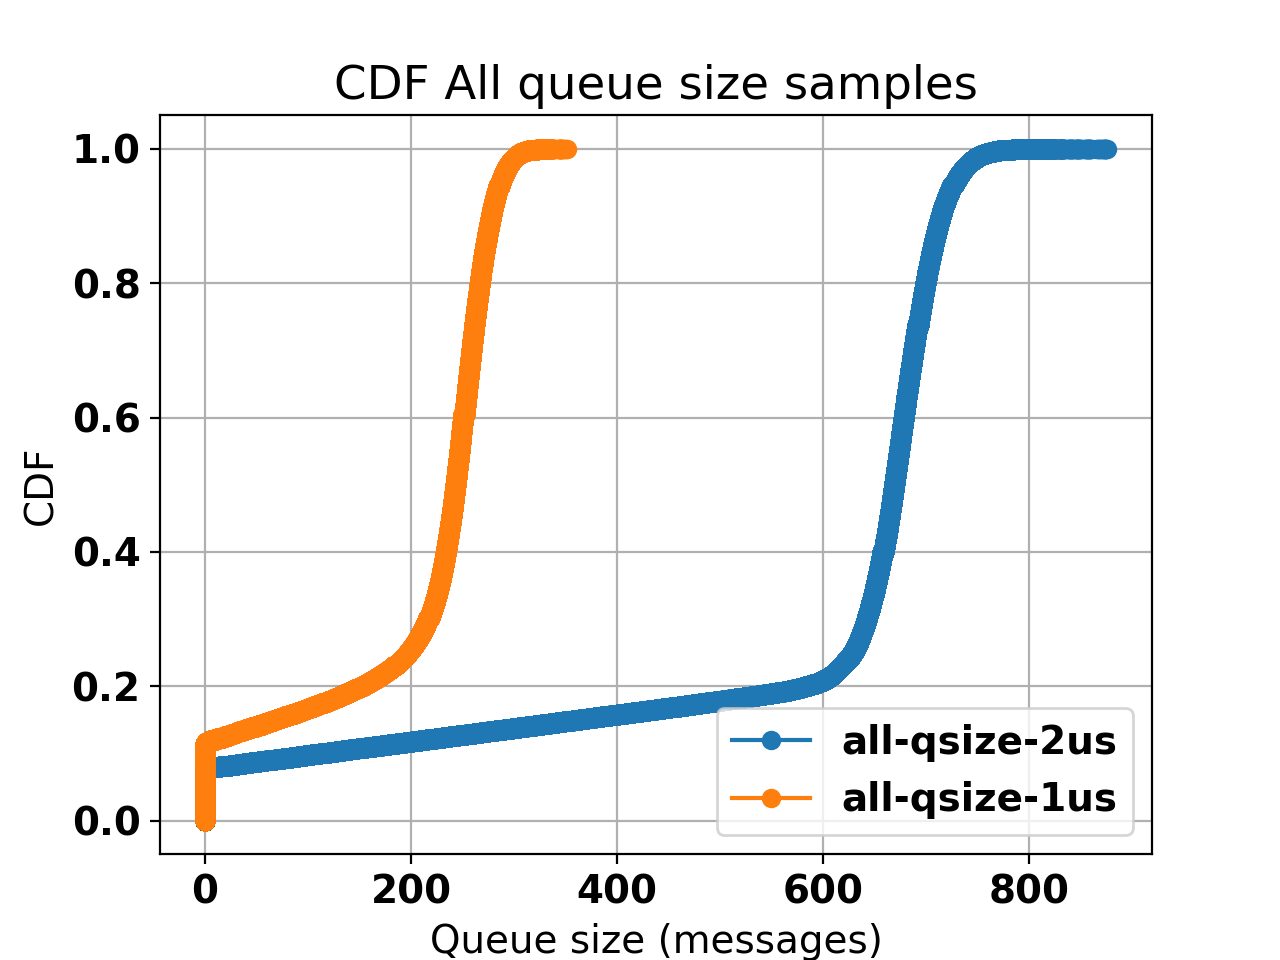

all-qsize-2us Statistics:
	99% = 753.0
	50% = 669.0
all-qsize-1us Statistics:
	99% = 303.0
	50% = 244.0


In [4]:
from plot_stats import plot_avg_qsize, plot_qsize_cdf

plot_avg_qsize('data/6-18-19/avg-qsize-2us.csv', 'data/6-18-19/avg-qsize-1us.csv')
plot_qsize_cdf('data/6-18-19/all-qsize-2us.csv', 'data/6-18-19/all-qsize-1us.csv')

# Experiment 2a - Exploring Host Queue Size

**Question:** Does the measured host queue size actually make sense?

#### Experiment Info:
* Using a constant branching factor of 5
* Using a constant service time of 1us
* 1000 Hosts
* Searching 8 levels into the Othello game tree
* 2us network communication delay between all hosts

#### Measurements:
* Just as in Experiment 1, the queue size of each host is sampled every 1us. We compute the average of all these samples and plot a time series of the average host queue occupancy.
* We also compute the expected long-term average queue occupancy for each host using [Little's result](https://en.wikipedia.org/wiki/Little%27s_law). To do so we use the following procedure:
    * Each host keeps track of the total number of messages that it removes from its queue over the duration of the simulation.
    * Each message is timestamped when it is inserted into the queue.
    * Each host keeps track of the total queueing delay of all messages that it removes from the queue.
    * `avg_arrival_rate = float(self.msg_count)/float(OthelloSimulator.finish_time)`
    * `avg_qtime = float(self.total_q_delay)/float(self.msg_count)`
    * `avg_qsize = avg_arrival_rate*avg_qtime`
    
#### Results
* If we compute the average of the queue size time series samples, we see that it agrees very well with the expected average queue occupancy that is computed using Little's result.


Creating plots ...


<IPython.core.display.Javascript object>


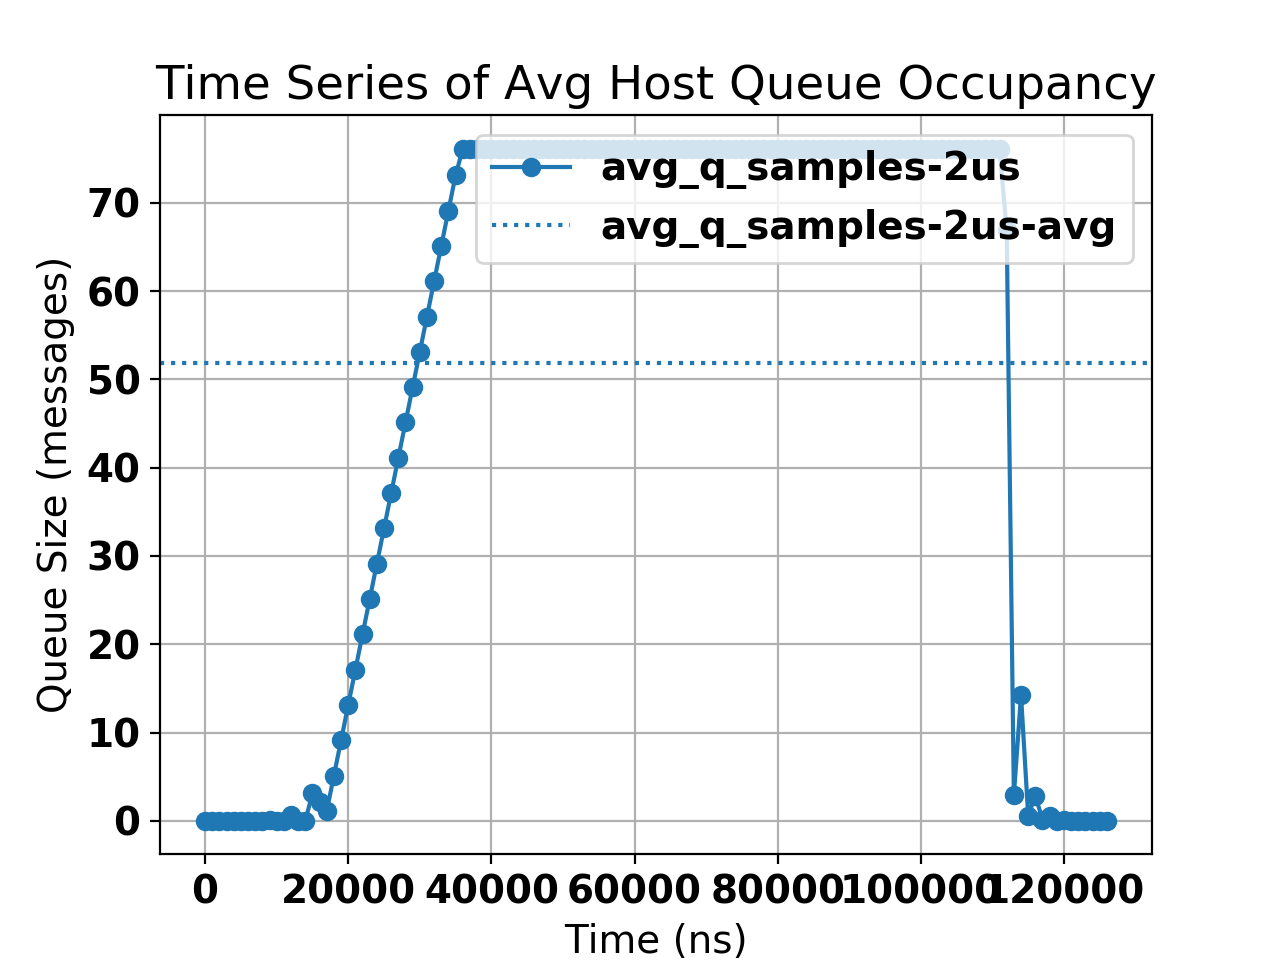

Creating plots ...


<IPython.core.display.Javascript object>


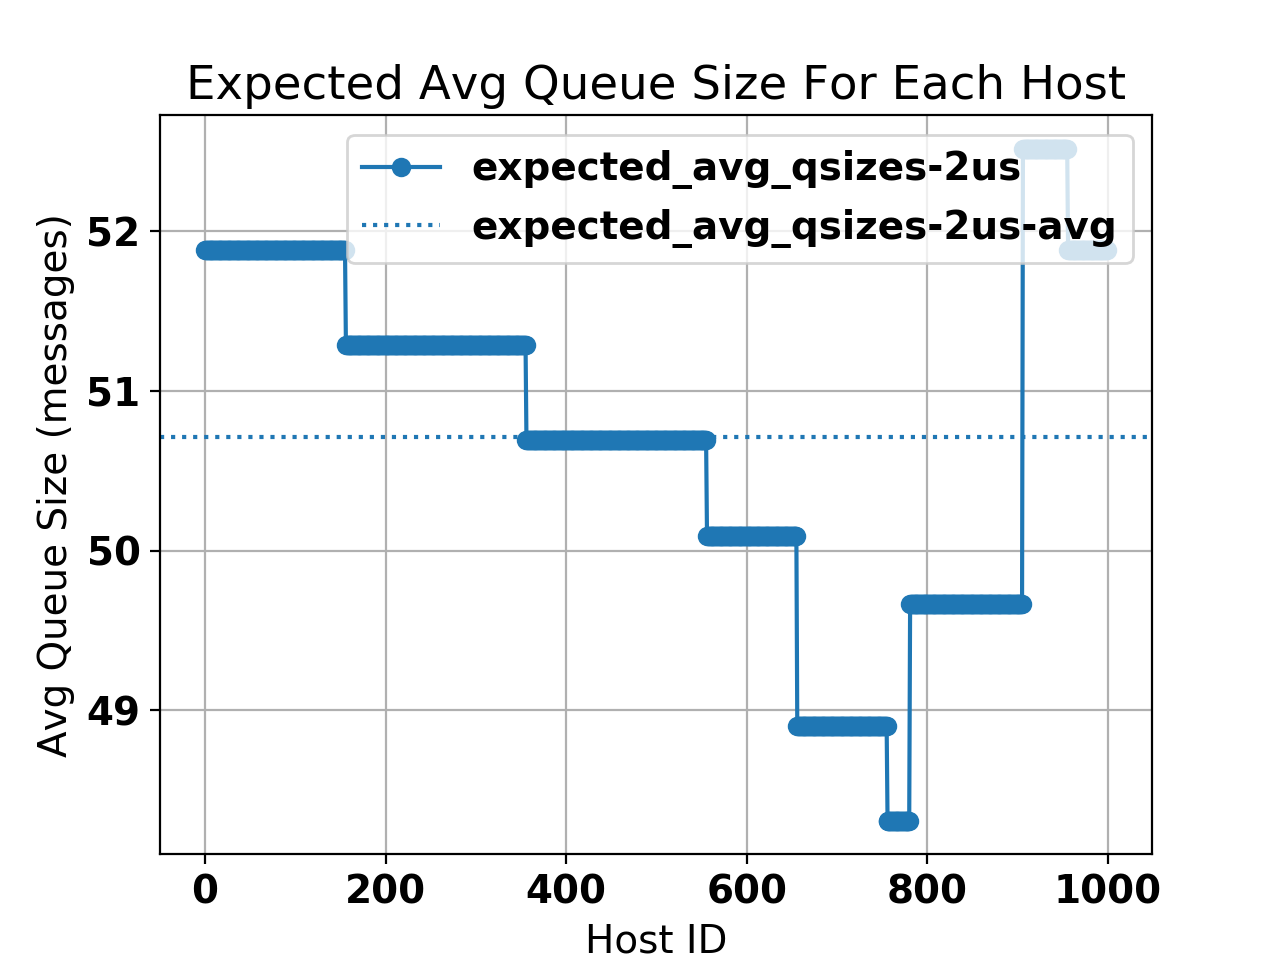

In [5]:
from plot_stats import plot_avg_qsize, plot_exp_avg_qsize

plot_avg_qsize('data/8L-1000H-5b-2us/avg_q_samples-2us.csv')
plot_exp_avg_qsize('data/8L-1000H-5b-2us/expected_avg_qsizes-2us.csv')

# Experiment 2b - Exploring the Effect of Network Communication Delay

#### Experiment Info:
* Using a constant branching factor of 5
* Using a constant service time of 1us
* 1000 Hosts
* Searching 8 levels into the Othello game tree
* Varying network communication delay (500ns - 3us)

#### Measurements:
* Simulation completion time
* Average CPU utilization - which is computed by dividing the total amount of time a host spent servicing Map requests by the total simulation time

#### Results:
* Simulation completion time:
    * 500ns delay => 108us
    * 1us delay => 114us 
    * 2us delay => 126us
    * 3us delay => 139us
* CPU Utilization - smaller communication delay leads to higher CPU utilization. This is probably the main reason why they complete faster.
* Also note that the load appears to be pretty evenly spread across the hosts, there is no significant difference in CPU utilization across hosts.

Creating plots ...


<IPython.core.display.Javascript object>


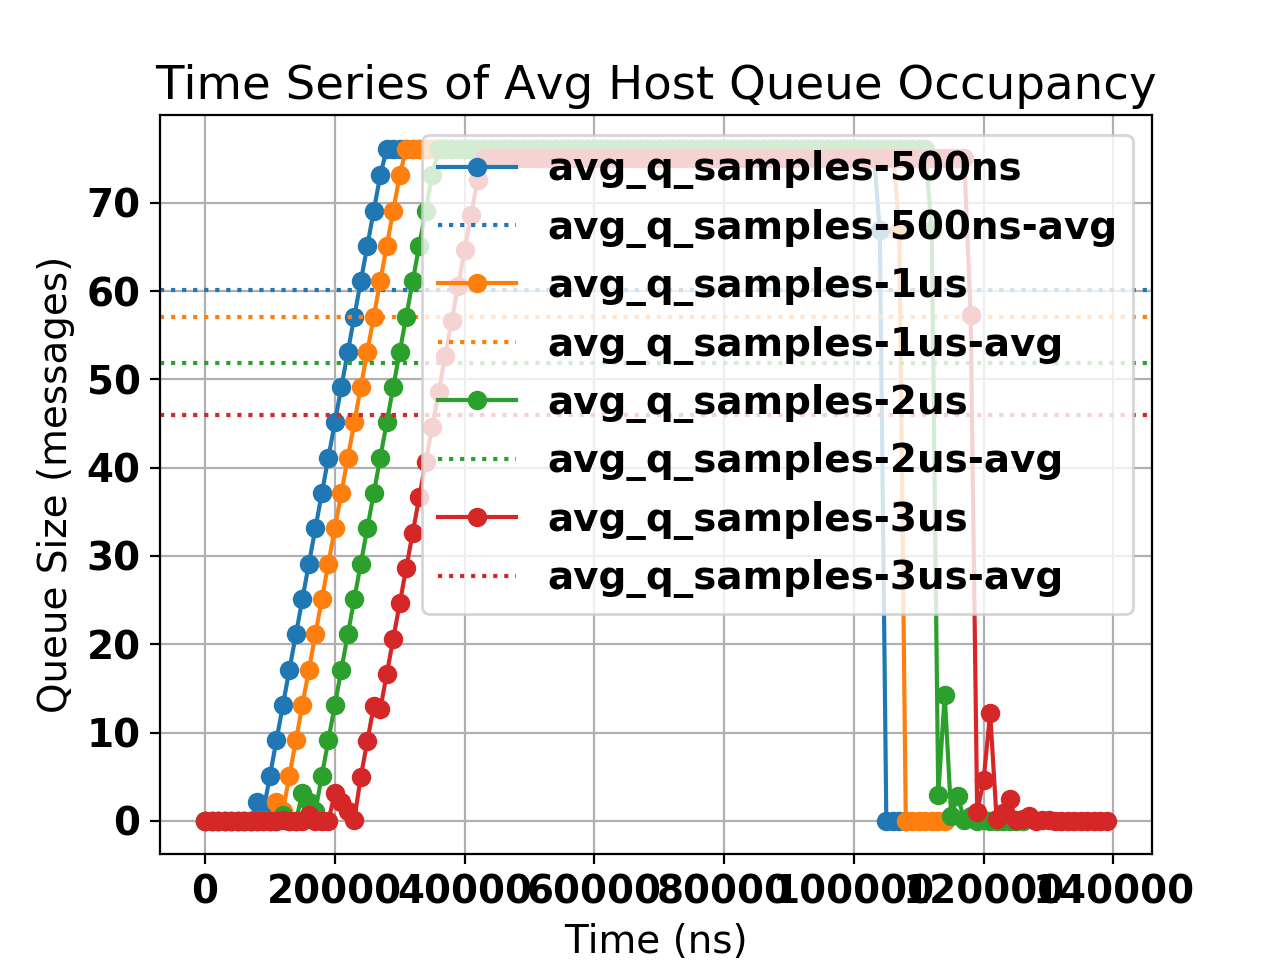

Creating plots ...


<IPython.core.display.Javascript object>


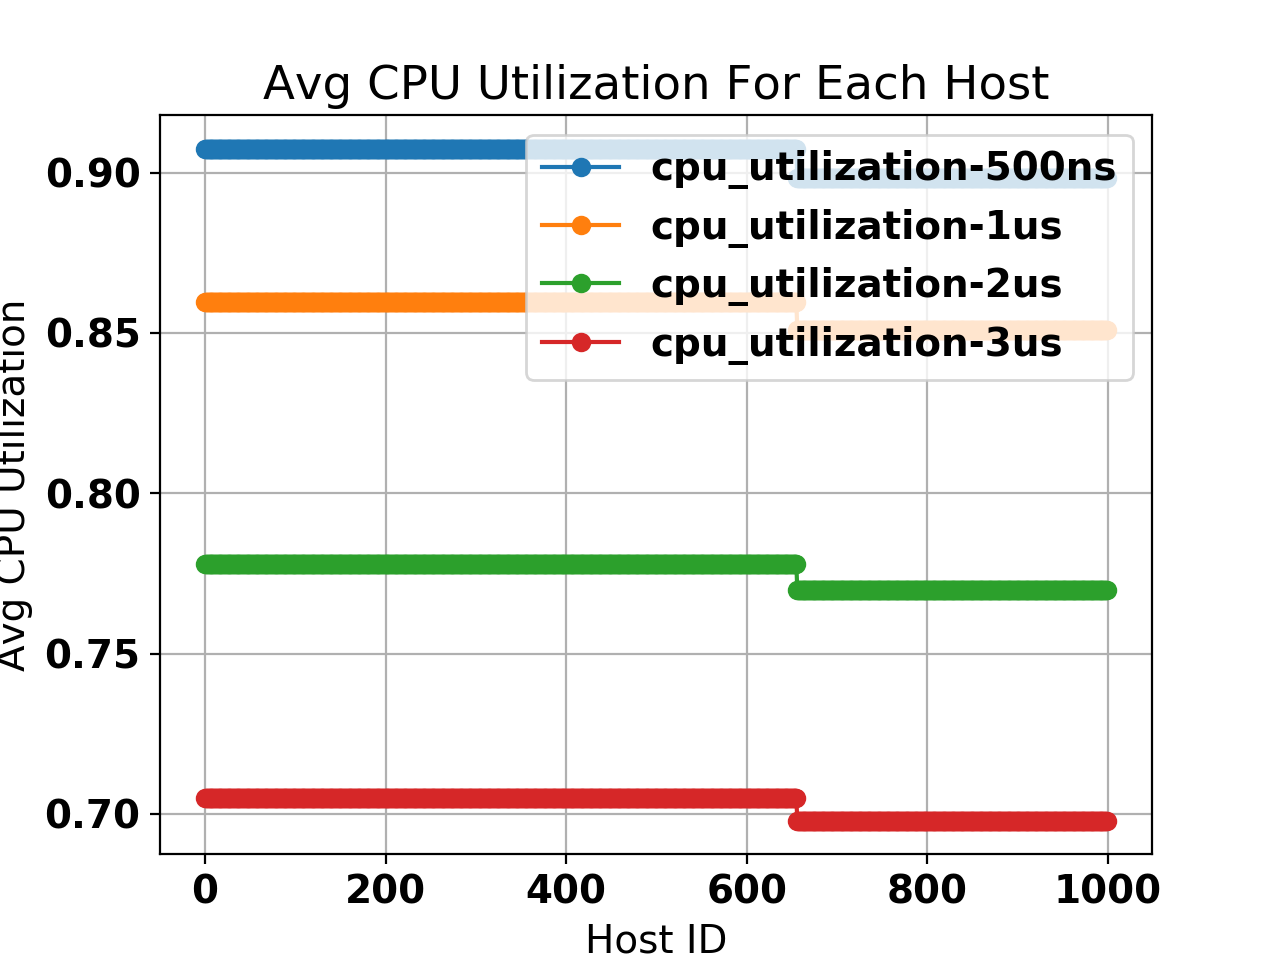

In [6]:
from plot_stats import plot_avg_qsize, plot_cpu_util

plot_avg_qsize('data/8L-1000H-5b-500ns/avg_q_samples-500ns.csv',
               'data/8L-1000H-5b-1us/avg_q_samples-1us.csv',
               'data/8L-1000H-5b-2us/avg_q_samples-2us.csv',
               'data/8L-1000H-5b-3us/avg_q_samples-3us.csv')
plot_cpu_util('data/8L-1000H-5b-500ns/cpu_utilization-500ns.csv',
              'data/8L-1000H-5b-1us/cpu_utilization-1us.csv',
              'data/8L-1000H-5b-2us/cpu_utilization-2us.csv',
              'data/8L-1000H-5b-3us/cpu_utilization-3us.csv')

# Experiment 3 - Exploring Effects on Tail Search Latency

**Question:** How does the tail search duration compare for the single core Othello implementation vs the distributed Othello implementation?

#### Experiment Info:
* The single core results are obtained using the [actual Othello implementation](https://github.com/l-nic/othello/tree/si/bit-board).
* The distributed results are obtained using the SimPy simulator with the following parameters:
    * Network communication delay = 1us
    * 1000 hosts
    * The service time for each map message is generated from the distribution at the [top of the page](https://han-1.stanford.edu:8888/notebooks/othello-sim/OthelloSimEvaluations.ipynb#Map-Message-Service-Time-CDF)
    * The branching factor is generated from the other distribution at the [top of the page](https://han-1.stanford.edu:8888/notebooks/othello-sim/OthelloSimEvaluations.ipynb#Branching-Factor-CDF)
* We evaluated how long each of these implementations take to evaluate a move for various search depths.
* We plot the search duration CDF for each implementation and for each depth.
* There are 300 samples for the distributed implementation and 3000 samples for the single core implementation.

#### Results:
* The distributions resulting from the distributed implementation are much tighter and have much lower tail latency.
* The simulation uses 1000 hosts, the average branching factor is about 7; so when searching 4 levels of less there is a sufficient number of hosts to ensure that there is never any queueing (must be at least 7^3 = 343 hosts). Up until D=4 the completion time increases linearly because it is only a function of the depth that is searched.
* Beyond D=4, queues start to build up and the completion time is affected by both the depth that is searched and the queueing delay. But the completion time distribution is still better than that of the single core implementation.


Creating plots ...


<IPython.core.display.Javascript object>


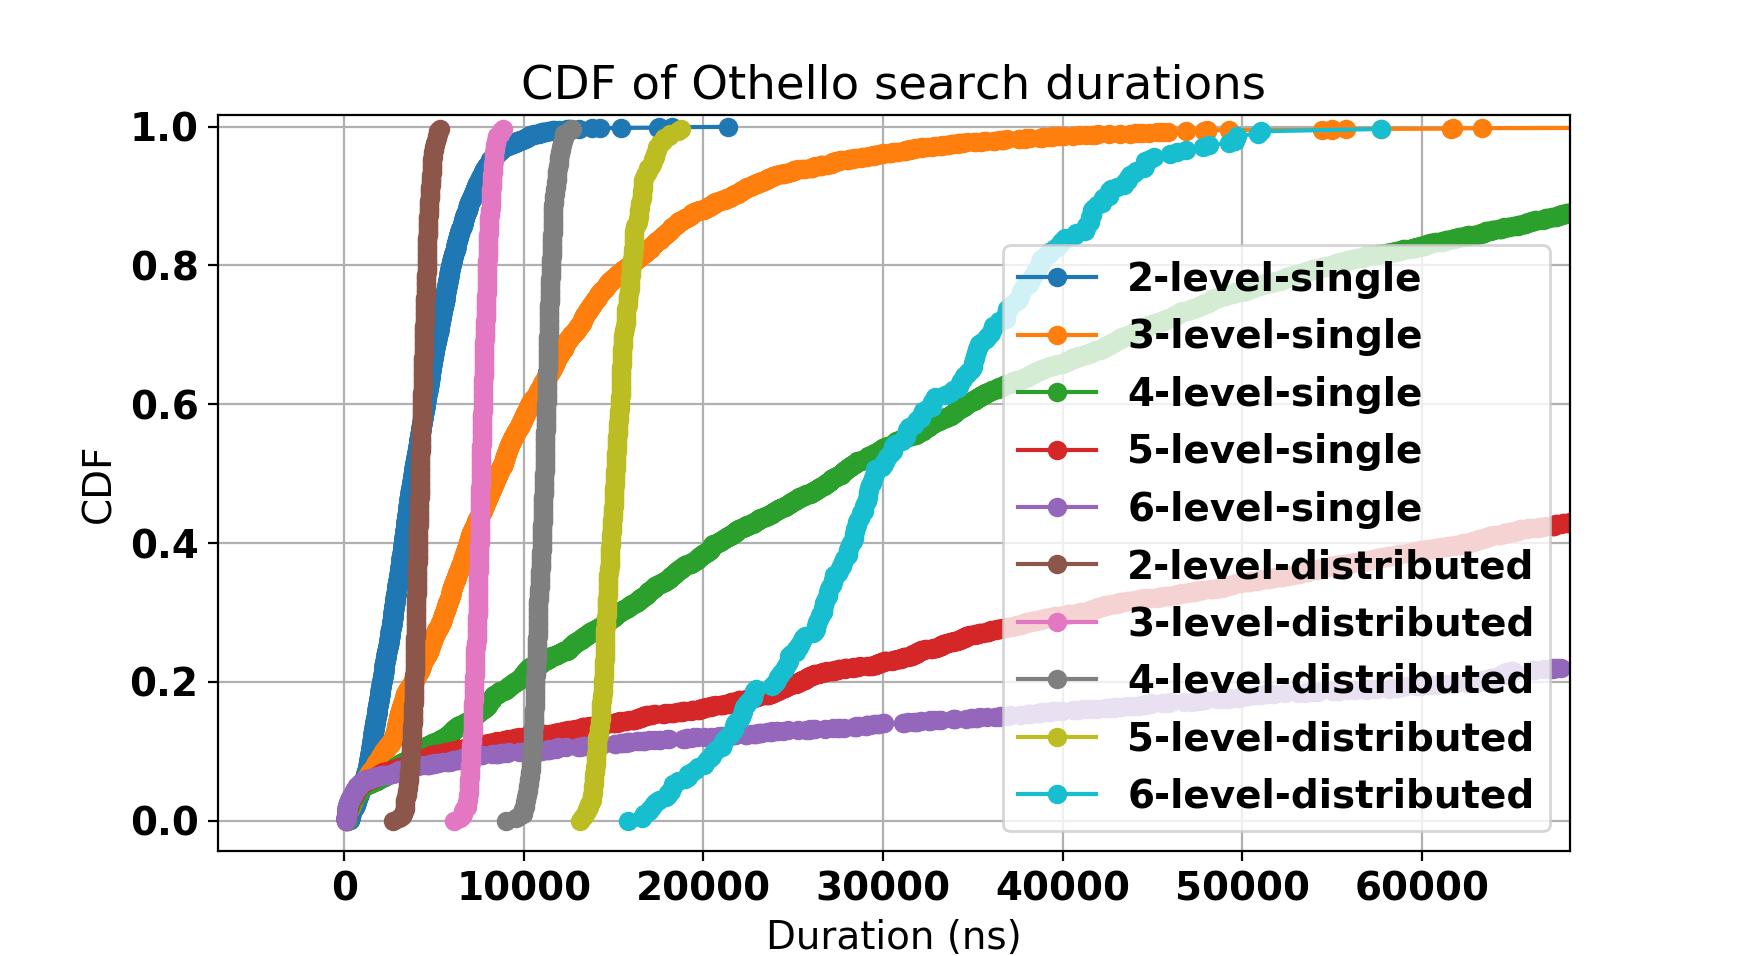

2-level-single Statistics:
	99% = 10745.79
	50% = 3850.0
3-level-single Statistics:
	99% = 43025.4
	50% = 8578.0
4-level-single Statistics:
	99% = 135347.16
	50% = 27675.0
5-level-single Statistics:
	99% = 561607.0
	50% = 83217.0
6-level-single Statistics:
	99% = 1845321.3
	50% = 245068.5
2-level-distributed Statistics:
	99% = 5164.52
	50% = 4216.5
3-level-distributed Statistics:
	99% = 8510.81
	50% = 7604.5
4-level-distributed Statistics:
	99% = 12215.01
	50% = 11149.0
5-level-distributed Statistics:
	99% = 18073.63
	50% = 15088.0
6-level-distributed Statistics:
	99% = 49717.66
	50% = 29514.0


In [15]:
from plot_stats import plot_search_cdf

plot_search_cdf('data/1000H-completion-times/2-level-single.csv',
                'data/1000H-completion-times/3-level-single.csv',
                'data/1000H-completion-times/4-level-single.csv',
                'data/1000H-completion-times/5-level-single.csv',
                'data/1000H-completion-times/6-level-single.csv',
                'data/1000H-completion-times/2-level-distributed.csv',
                'data/1000H-completion-times/3-level-distributed.csv',
                'data/1000H-completion-times/4-level-distributed.csv',
                'data/1000H-completion-times/5-level-distributed.csv',
                'data/1000H-completion-times/6-level-distributed.csv')

# Experiment 4 - Register File vs DDIO vs Main Memory

#### Experiment Info:
* Using a constant branching factor = 5
* Using a constant service time = 1us
* Network fabric delay = 1us
* 1000 Hosts
* Searching 8 levels into the Othello game tree
* Various NIC types: register file / DDIO / Main Memory
* `nicBufSize` = 100 messages
* `llcSize` = 1000 messages
* `memDelay` = 1us
* `llcDelay` = 1us
* `regDelay` = 200 ns
* `memAccessTime` = 100 ns
* `llcAccessTime` = 10 ns
* `regAccessTime` = 0 ns

#### Register file vs. DDIO vs. Main Memory

* The network communication delay consists of the network fabric delay + the delay from the NIC into the appropriate memory location (i.e. RegFile/LLC/MainMem)
* Then when a message is enqueued into the host's queue, depending on the size of the queue, that message might evict an older message into a higher level of the memory hierarchy. Each host uses a stack to keep track of memory access times, either `regAccessTime`, `llcAccessTime`, or `memAccessTime` will be pushed onto the stack when a message is enqueued (depending on the current size of the queue)
* The memory access time is modeled when the host pulls a message out of the queue
* The main reason for the difference in CPU utilization between `nicType` = reg and `nicType` = ddio is indeed because of the smaller communication latency. However, the main reason for the difference in CPU utilization between `nicType` = ddio and `nicType` = mem is not because of the smaller communication latency. It is actually because the CPU needs to fetch every message from main memory which means there is always a 100ns delay between processing every message, which cannot be pipelined. In reality, this may not be completely accurate because the CPU can use pre-fetching / spatial locality, but maybe it's ok not to model those aspects?


Creating plots ...


<IPython.core.display.Javascript object>


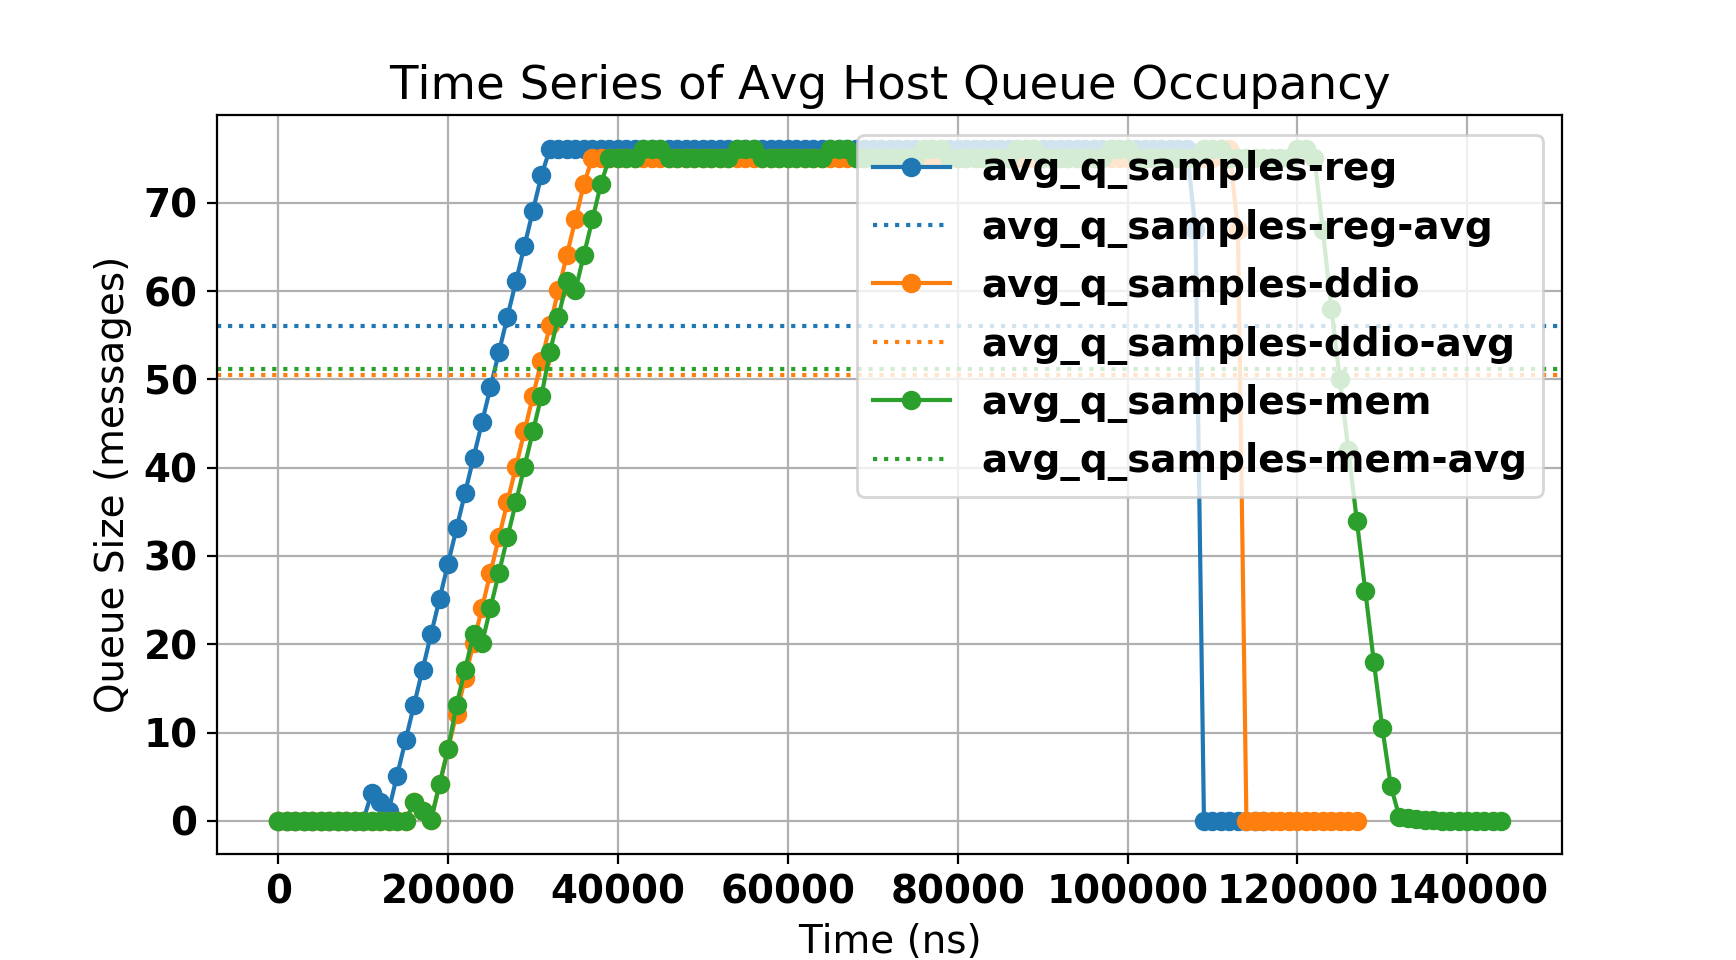

Creating plots ...


<IPython.core.display.Javascript object>


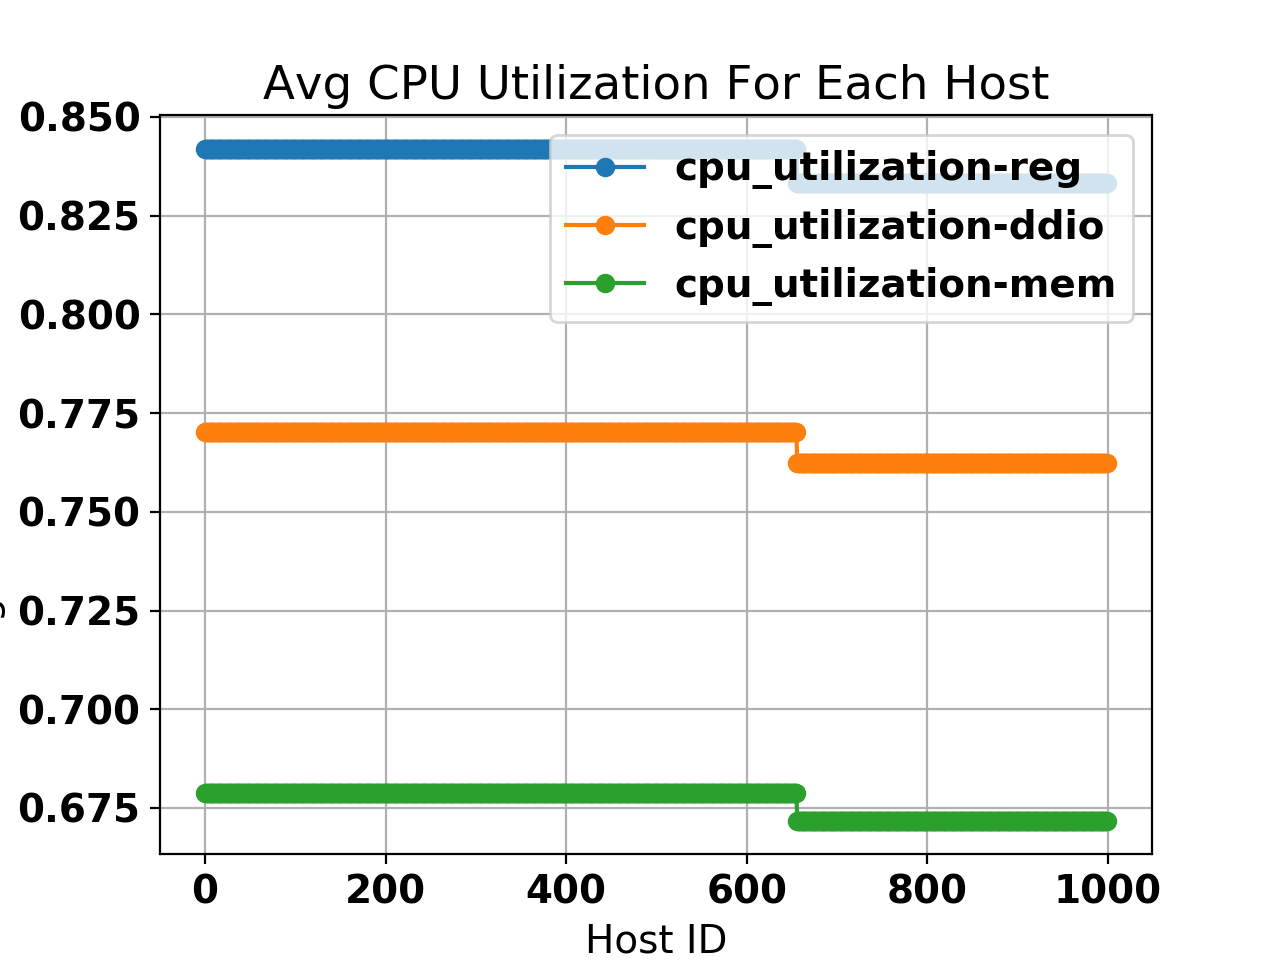

In [17]:
from plot_stats import plot_avg_qsize, plot_cpu_util

plot_avg_qsize('data/8L-1000H-5b-reg/avg_q_samples-reg.csv',
               'data/8L-1000H-5b-ddio/avg_q_samples-ddio.csv',
               'data/8L-1000H-5b-mem/avg_q_samples-mem.csv')
plot_cpu_util('data/8L-1000H-5b-reg/cpu_utilization-reg.csv',
              'data/8L-1000H-5b-ddio/cpu_utilization-ddio.csv',
              'data/8L-1000H-5b-mem/cpu_utilization-mem.csv')

### Experiment 4b

The following plots use the service time distribution and the branching factor distribution to explore the CDF of the completion times for the register file vs. DDIO vs. MainMemory implementations

Creating plots ...


<IPython.core.display.Javascript object>


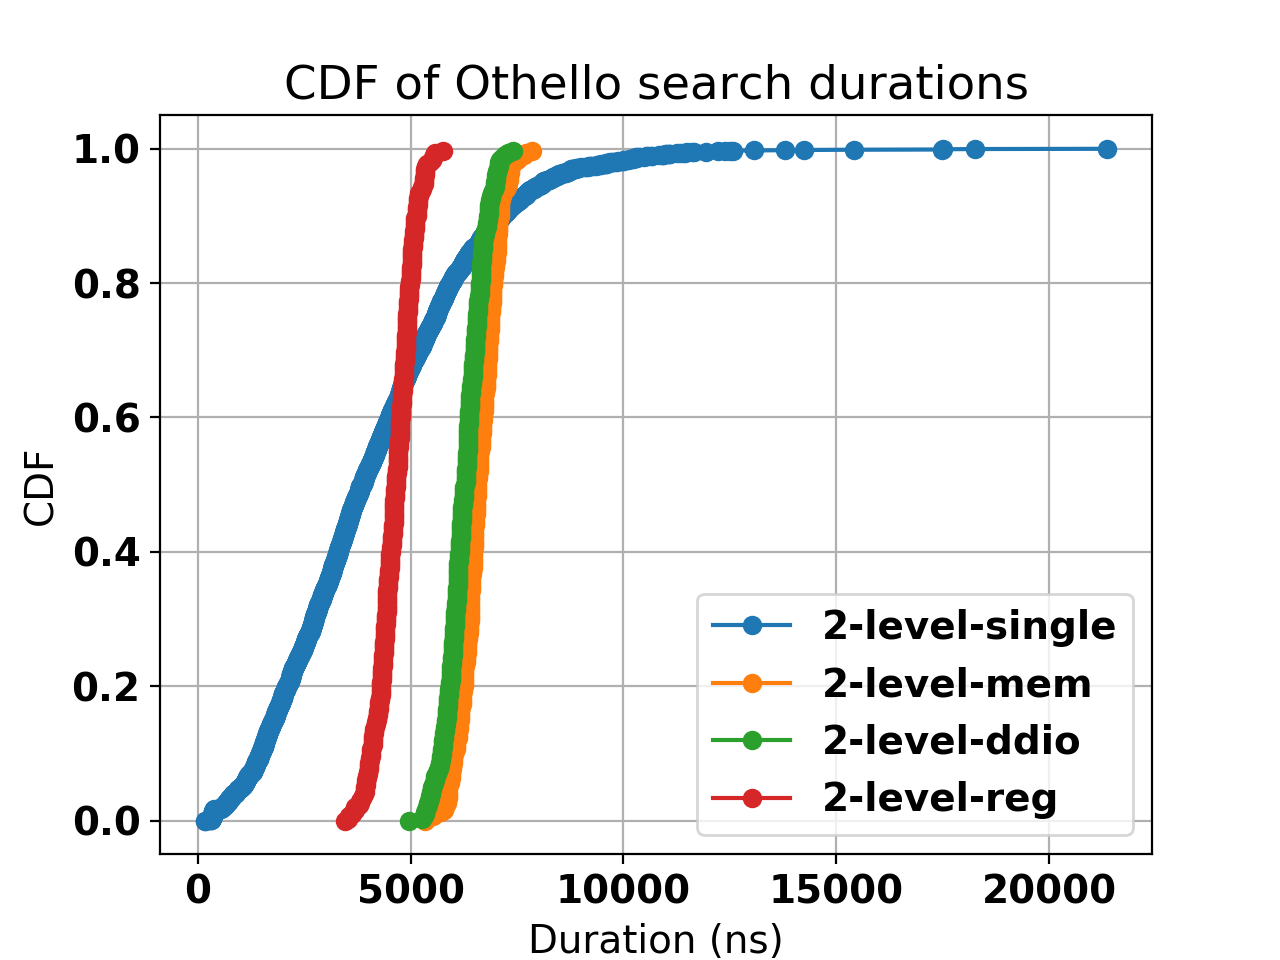

2-level-single Statistics:
	99% = 10745.79
	50% = 3850.0
2-level-mem Statistics:
	99% = 7548.29
	50% = 6558.5
2-level-ddio Statistics:
	99% = 7160.6
	50% = 6275.0
2-level-reg Statistics:
	99% = 5517.3
	50% = 4650.0
Creating plots ...


<IPython.core.display.Javascript object>


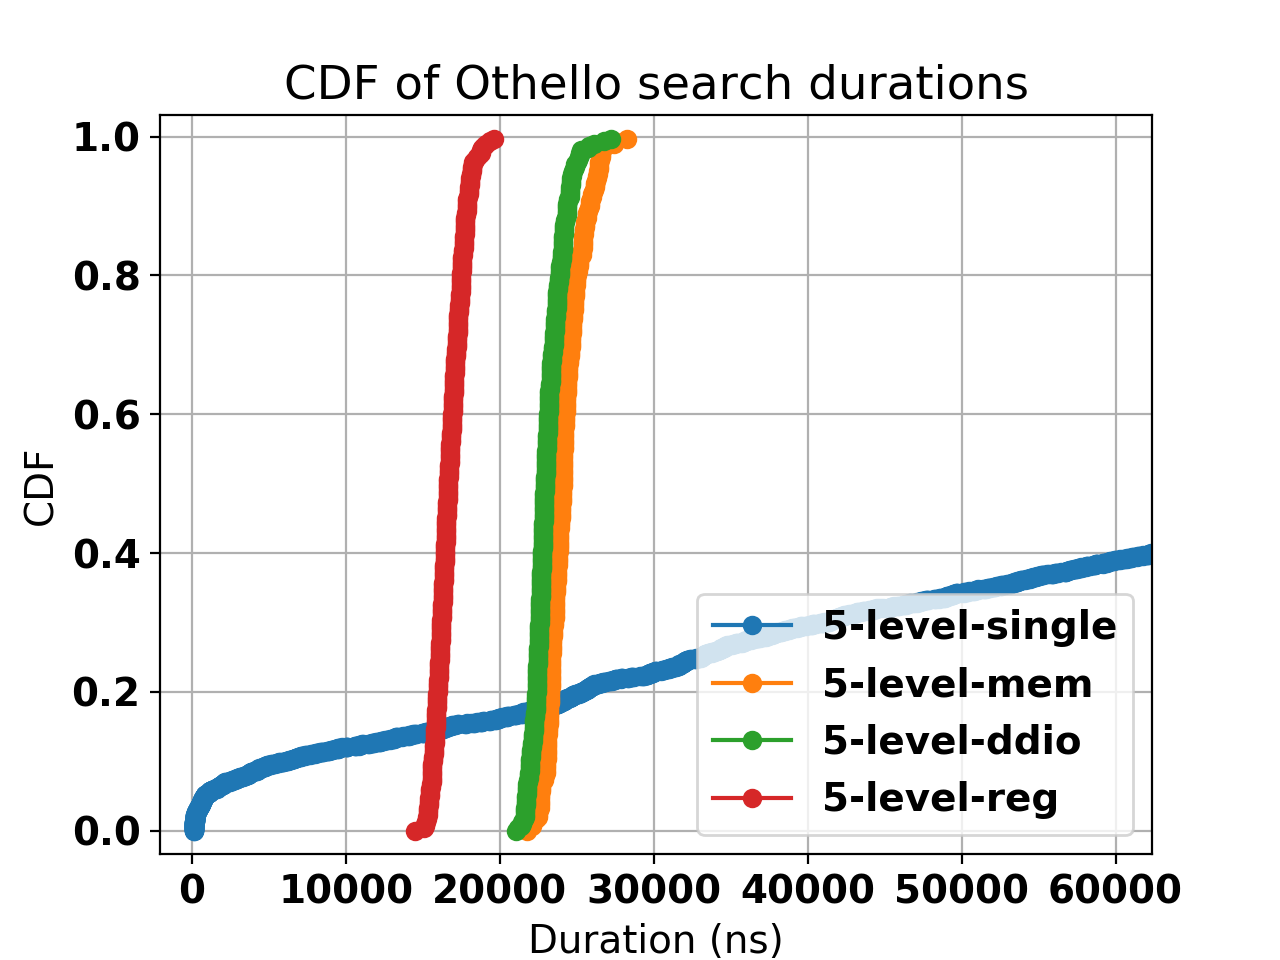

5-level-single Statistics:
	99% = 561607.0
	50% = 83217.0
5-level-mem Statistics:
	99% = 26807.06
	50% = 24078.0
5-level-ddio Statistics:
	99% = 25802.46
	50% = 22931.0
5-level-reg Statistics:
	99% = 18995.37
	50% = 16651.5
Creating plots ...


<IPython.core.display.Javascript object>


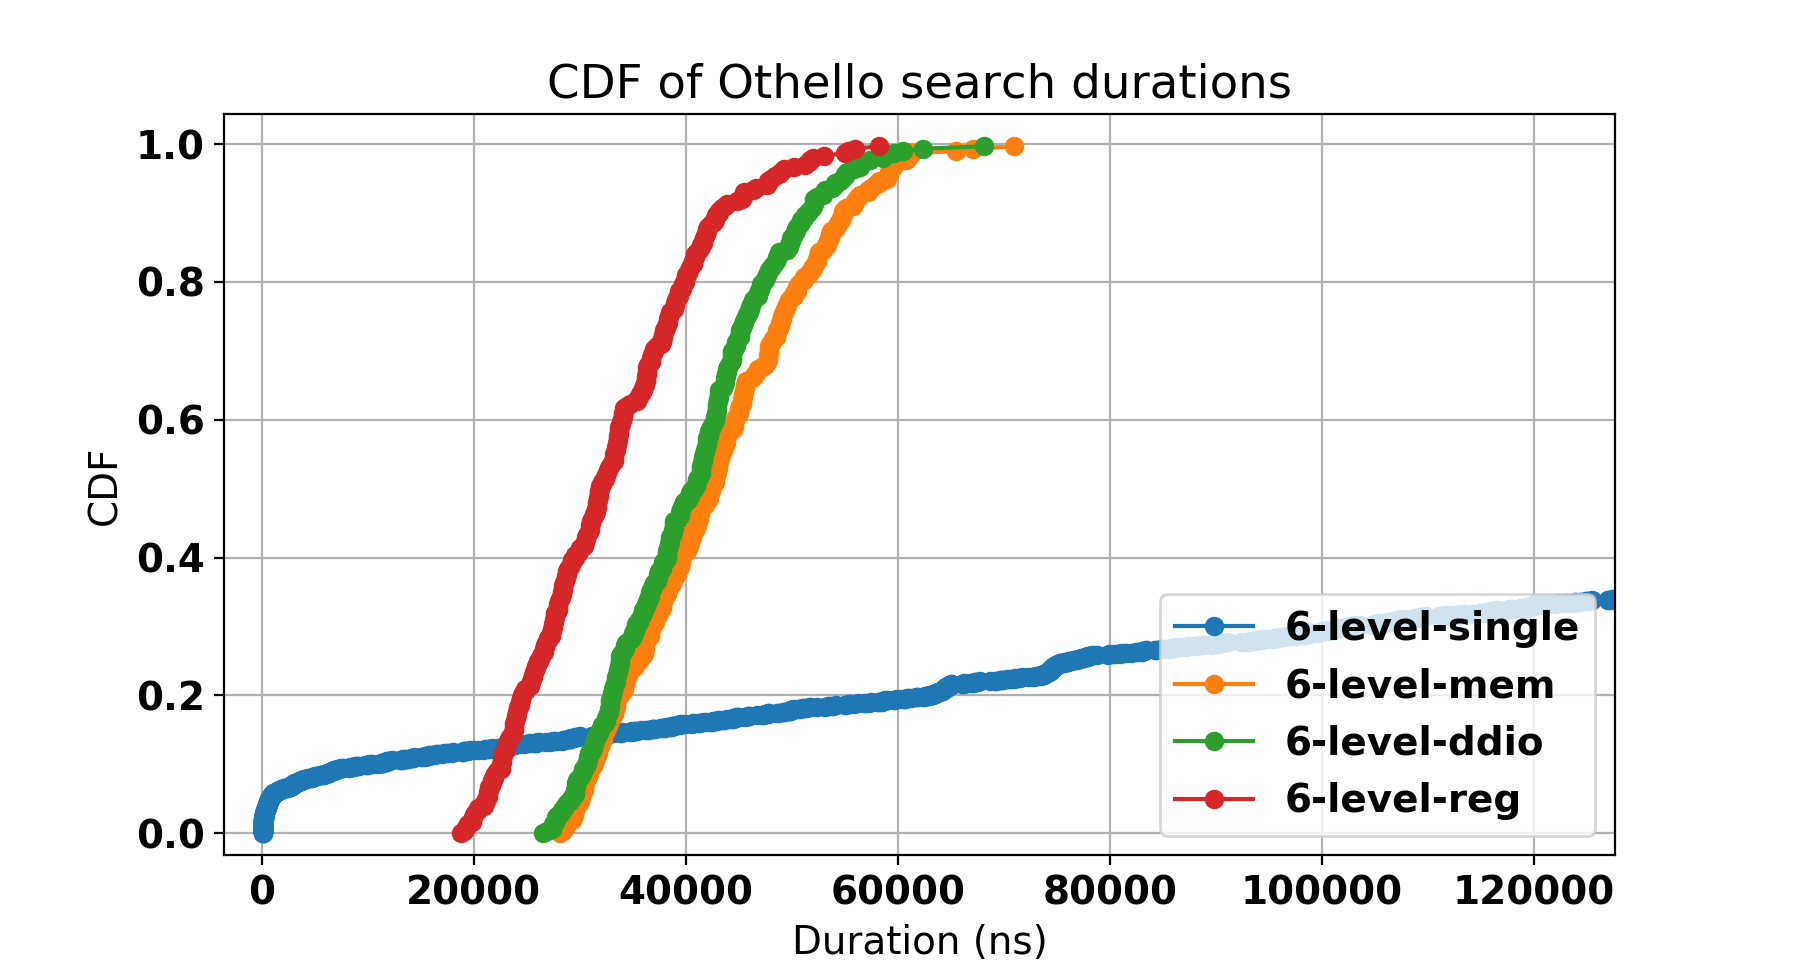

6-level-single Statistics:
	99% = 1845321.3
	50% = 245068.5
6-level-mem Statistics:
	99% = 61429.52
	50% = 42372.5
6-level-ddio Statistics:
	99% = 59626.13
	50% = 40602.0
6-level-reg Statistics:
	99% = 55075.1
	50% = 31890.0


In [34]:
from plot_stats import plot_search_cdf

plot_search_cdf('data/single-core-completions/2-level-single.csv',
                'data/6-20-19/completion_times/2-level-mem.csv',
                'data/6-20-19/completion_times/2-level-ddio.csv',
                'data/6-20-19/completion_times/2-level-reg.csv')

# plot_search_cdf('data/single-core-completions/3-level-single.csv',
#                 'data/6-20-19/completion_times/3-level-mem.csv',
#                 'data/6-20-19/completion_times/3-level-ddio.csv',
#                 'data/6-20-19/completion_times/3-level-reg.csv')

# plot_search_cdf('data/single-core-completions/4-level-single.csv',
#                 'data/6-20-19/completion_times/4-level-mem.csv',
#                 'data/6-20-19/completion_times/4-level-ddio.csv',
#                 'data/6-20-19/completion_times/4-level-reg.csv')

plot_search_cdf('data/single-core-completions/5-level-single.csv',
                'data/6-20-19/completion_times/5-level-mem.csv',
                'data/6-20-19/completion_times/5-level-ddio.csv',
                'data/6-20-19/completion_times/5-level-reg.csv')

plot_search_cdf('data/single-core-completions/6-level-single.csv',
                'data/6-20-19/completion_times/6-level-mem.csv',
                'data/6-20-19/completion_times/6-level-ddio.csv',
                'data/6-20-19/completion_times/6-level-reg.csv')


# Summary of the Important Takeaways

* The completion time distribution of the distributed Othello implementation is much better than that of the single core Othello implementation.
    * When using 1000 machines, the distributed implementation improves the 99% tail completion time by ~30x
* In order to improve the performance of the distributed implementation we need to minimize the network communication latency. This allows messages to get out to CPUs faster hence increasing CPU utilization and reducing completion time.

# Experiment 5 - Effect of Modeling Reduce Message Service Time

#### Background
* Previous experiments have only modeled the service time to process map messages and have ignored the service time to process reduce messages.
* In a real implementation there will be a non-negligible service time to process the reduce messages. The host must lookup some state associated with the reduce message and increment a counter so that it knows when it has received all the required reduce messages and can send a result upstream.
* Modeling the reduce service time causes queues to build up during the reduce phase.

**Question:** How does modeling the reduce message service time effect the completion time CDF?

#### Experiment Info
* 1000 hosts
* Using map message service time distribution and branching factor distribution
* Constant reduce message service time = 500ns (service time of RAM Cloud in the best case)

#### Results
* The avg completion time increases by a constant factor of 1.5x and the distribution becomes a bit wider

Creating plots ...


<IPython.core.display.Javascript object>


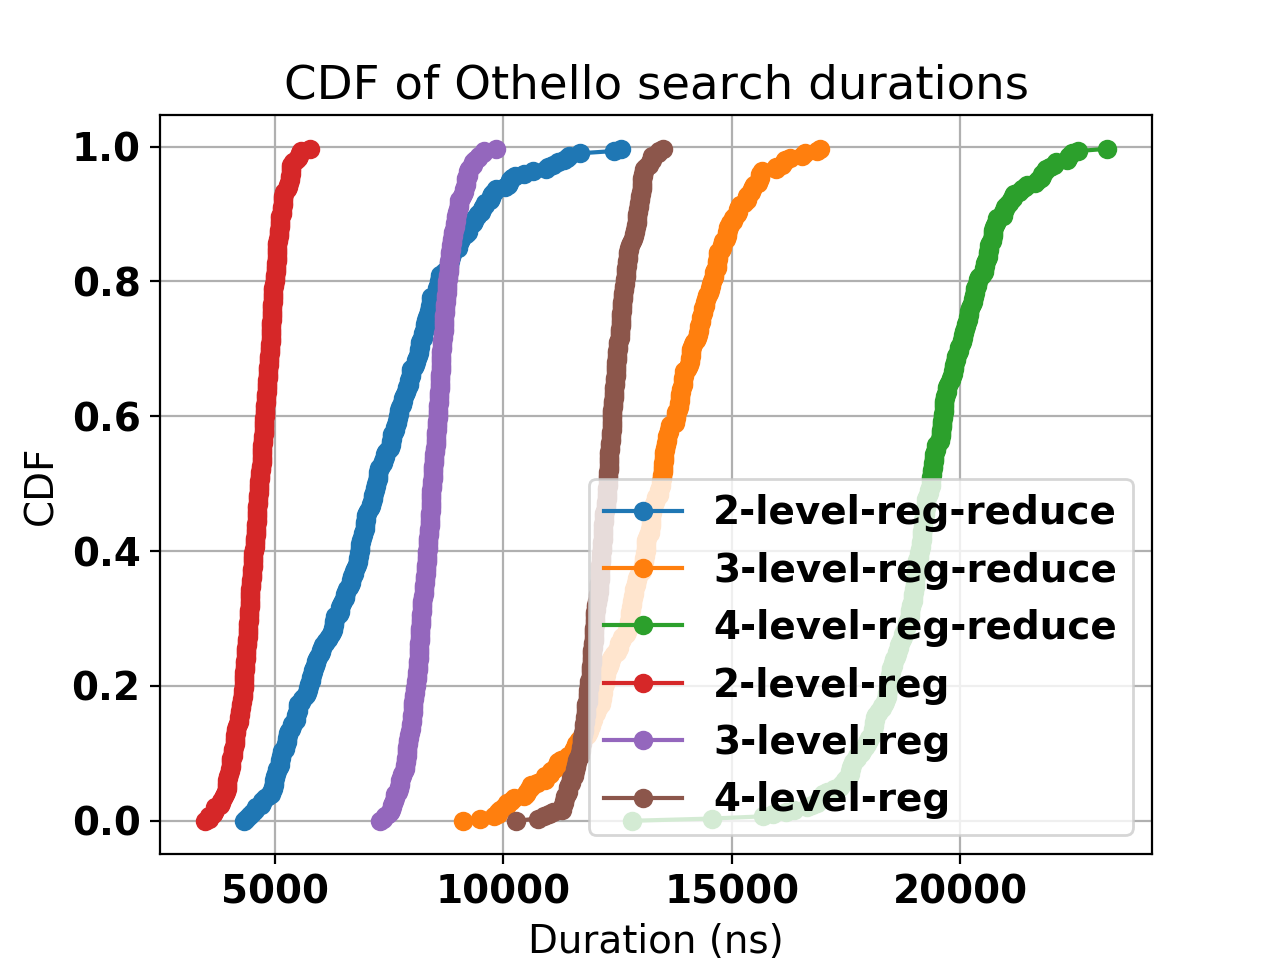

2-level-reg-reduce Statistics:
	99% = 11436.49
	50% = 7205.5
3-level-reg-reduce Statistics:
	99% = 16550.53
	50% = 13449.5
4-level-reg-reduce Statistics:
	99% = 22378.76
	50% = 19362.0
2-level-reg Statistics:
	99% = 5517.3
	50% = 4650.0
3-level-reg Statistics:
	99% = 9473.88
	50% = 8432.0
4-level-reg Statistics:
	99% = 13251.39
	50% = 12285.0


In [38]:
from plot_stats import plot_search_cdf

plot_search_cdf('data/6-20-19/completion_times_reduce/2-level-reg-reduce.csv',
                'data/6-20-19/completion_times_reduce/3-level-reg-reduce.csv',
                'data/6-20-19/completion_times_reduce/4-level-reg-reduce.csv',
                'data/6-20-19/completion_times/2-level-reg.csv',
                'data/6-20-19/completion_times/3-level-reg.csv',
                'data/6-20-19/completion_times/4-level-reg.csv')

---

## Some more tests ... 

Results using a modulo hash function for host selection at the switch: 

```
dst = msg.ID % len(self.hosts)
```

Creating plots ...


<IPython.core.display.Javascript object>


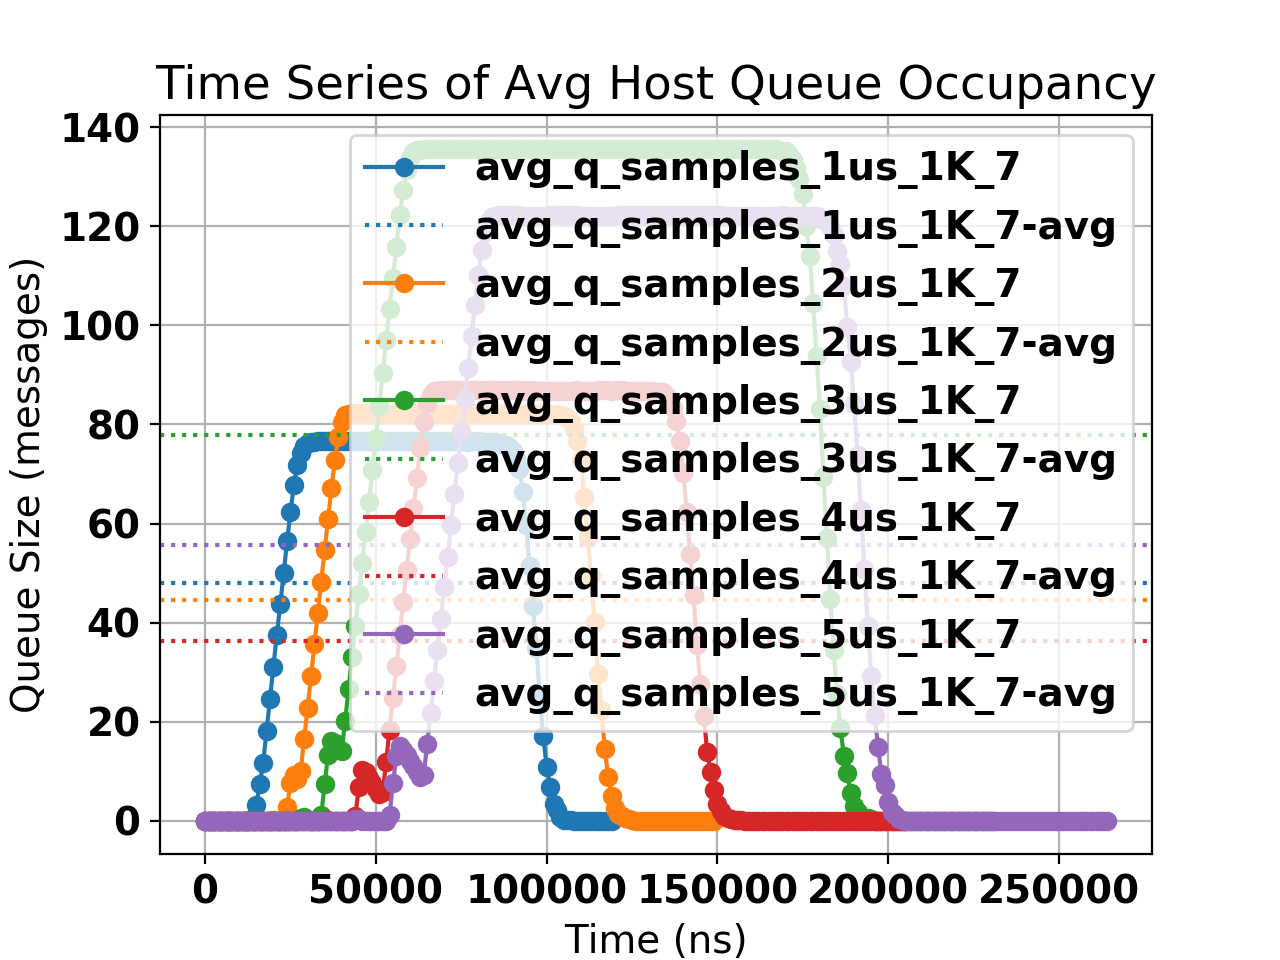

Creating plots ...


<IPython.core.display.Javascript object>


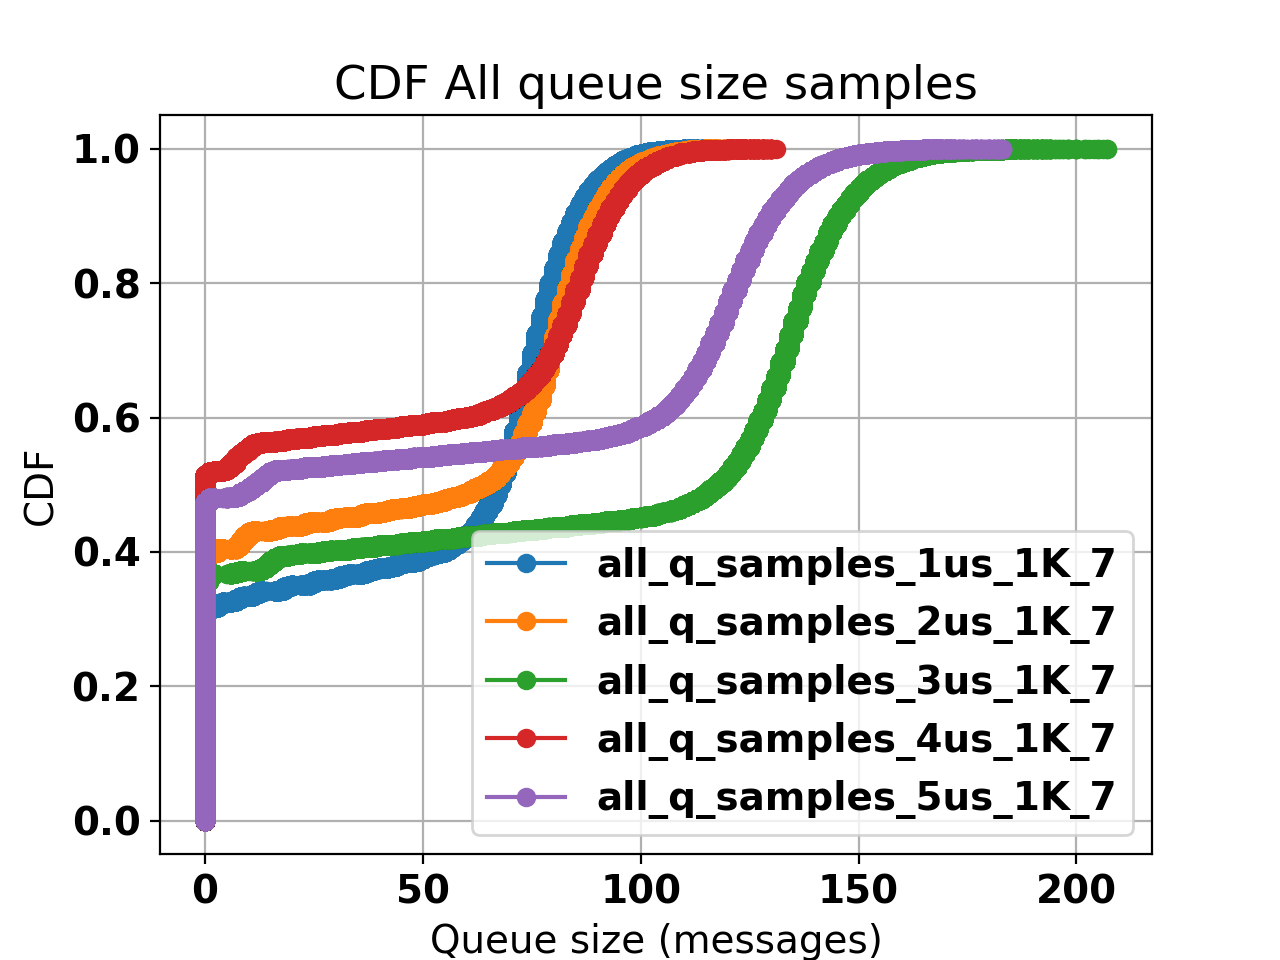

all_q_samples_1us_1K_7 Statistics:
	99% = 99.0
	50% = 68.0
all_q_samples_2us_1K_7 Statistics:
	99% = 105.0
	50% = 64.0
all_q_samples_3us_1K_7 Statistics:
	99% = 165.0
	50% = 118.0
all_q_samples_4us_1K_7 Statistics:
	99% = 108.0
	50% = 0.0
all_q_samples_5us_1K_7 Statistics:
	99% = 149.0
	50% = 12.0


In [8]:
from plot_stats import plot_avg_qsize, plot_qsize_cdf

plot_avg_qsize('data/6-18-19-MS/avg_q_samples_1us_1K_7.csv',
               'data/6-18-19-MS/avg_q_samples_2us_1K_7.csv',
               'data/6-18-19-MS/avg_q_samples_3us_1K_7.csv',
               'data/6-18-19-MS/avg_q_samples_4us_1K_7.csv',
               'data/6-18-19-MS/avg_q_samples_5us_1K_7.csv')
plot_qsize_cdf('data/6-18-19-MS/all_q_samples_1us_1K_7.csv',
               'data/6-18-19-MS/all_q_samples_2us_1K_7.csv',
               'data/6-18-19-MS/all_q_samples_3us_1K_7.csv',
               'data/6-18-19-MS/all_q_samples_4us_1K_7.csv',
               'data/6-18-19-MS/all_q_samples_5us_1K_7.csv')

### Fixed seed
Results using a fixed seed, i.e., np.random.seed(1)

Creating plots ...


<IPython.core.display.Javascript object>


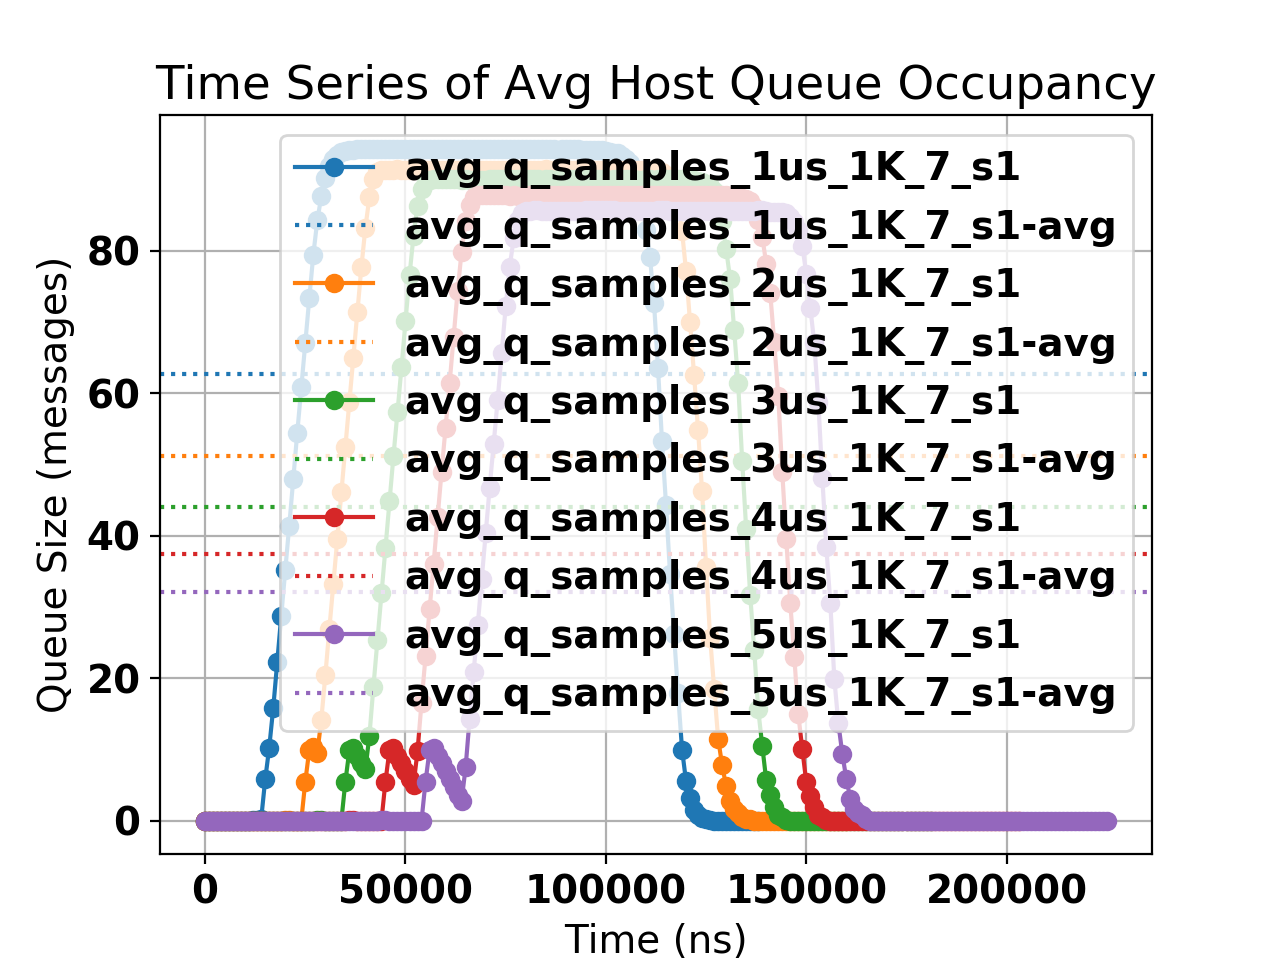

Creating plots ...


<IPython.core.display.Javascript object>


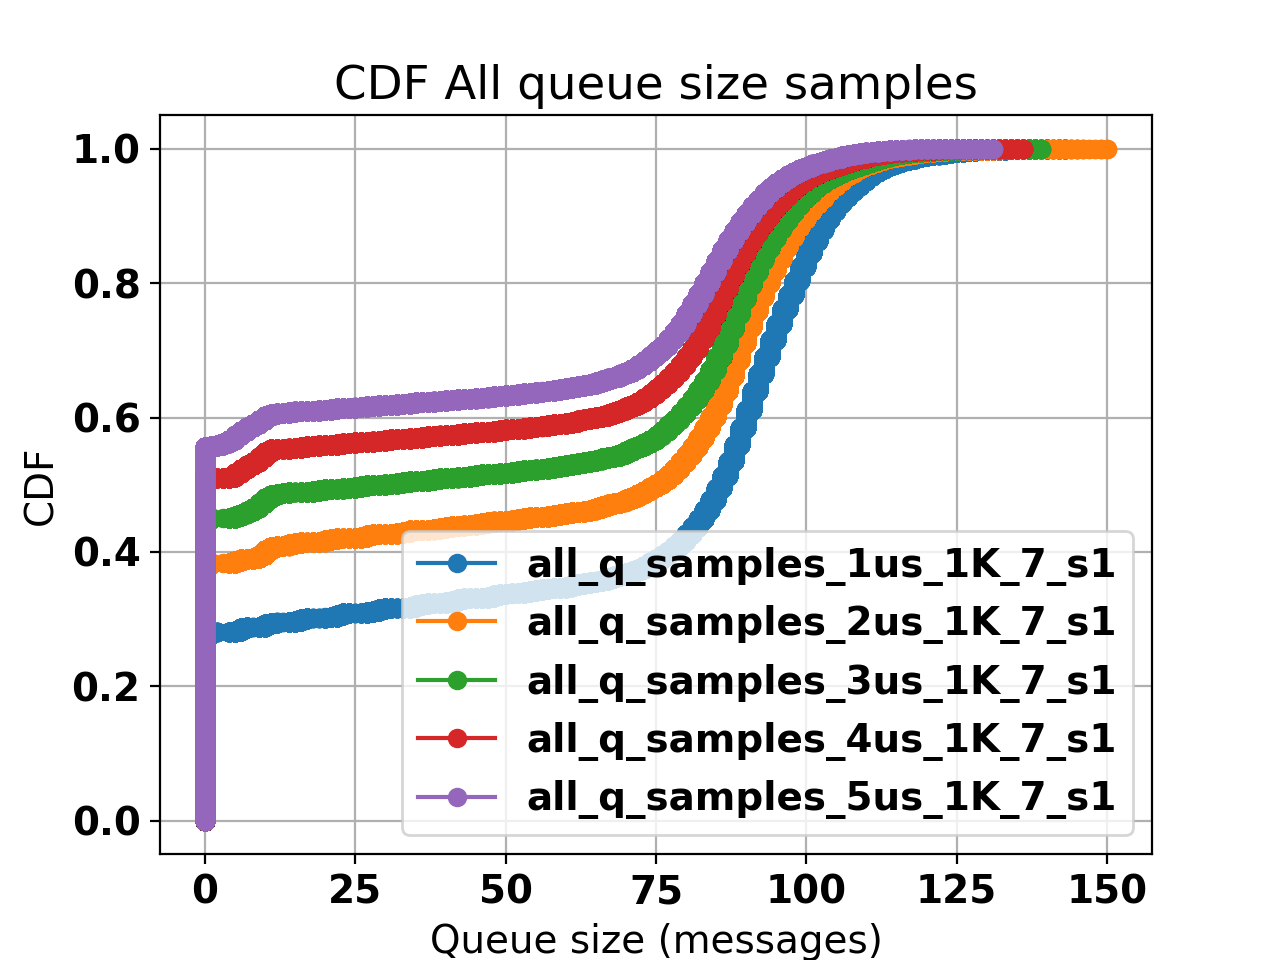

all_q_samples_1us_1K_7_s1 Statistics:
	99% = 120.0
	50% = 86.0
all_q_samples_2us_1K_7_s1 Statistics:
	99% = 116.0
	50% = 75.0
all_q_samples_3us_1K_7_s1 Statistics:
	99% = 114.0
	50% = 29.0
all_q_samples_4us_1K_7_s1 Statistics:
	99% = 111.0
	50% = 0.0
all_q_samples_5us_1K_7_s1 Statistics:
	99% = 107.0
	50% = 0.0


In [9]:
from plot_stats import plot_avg_qsize, plot_qsize_cdf

plot_avg_qsize('data/6-18-19-MS/avg_q_samples_1us_1K_7_s1.csv',
               'data/6-18-19-MS/avg_q_samples_2us_1K_7_s1.csv',
               'data/6-18-19-MS/avg_q_samples_3us_1K_7_s1.csv',
               'data/6-18-19-MS/avg_q_samples_4us_1K_7_s1.csv',
               'data/6-18-19-MS/avg_q_samples_5us_1K_7_s1.csv')
plot_qsize_cdf('data/6-18-19-MS/all_q_samples_1us_1K_7_s1.csv',
               'data/6-18-19-MS/all_q_samples_2us_1K_7_s1.csv',
               'data/6-18-19-MS/all_q_samples_3us_1K_7_s1.csv',
               'data/6-18-19-MS/all_q_samples_4us_1K_7_s1.csv',
               'data/6-18-19-MS/all_q_samples_5us_1K_7_s1.csv')

Creating plots ...


<IPython.core.display.Javascript object>


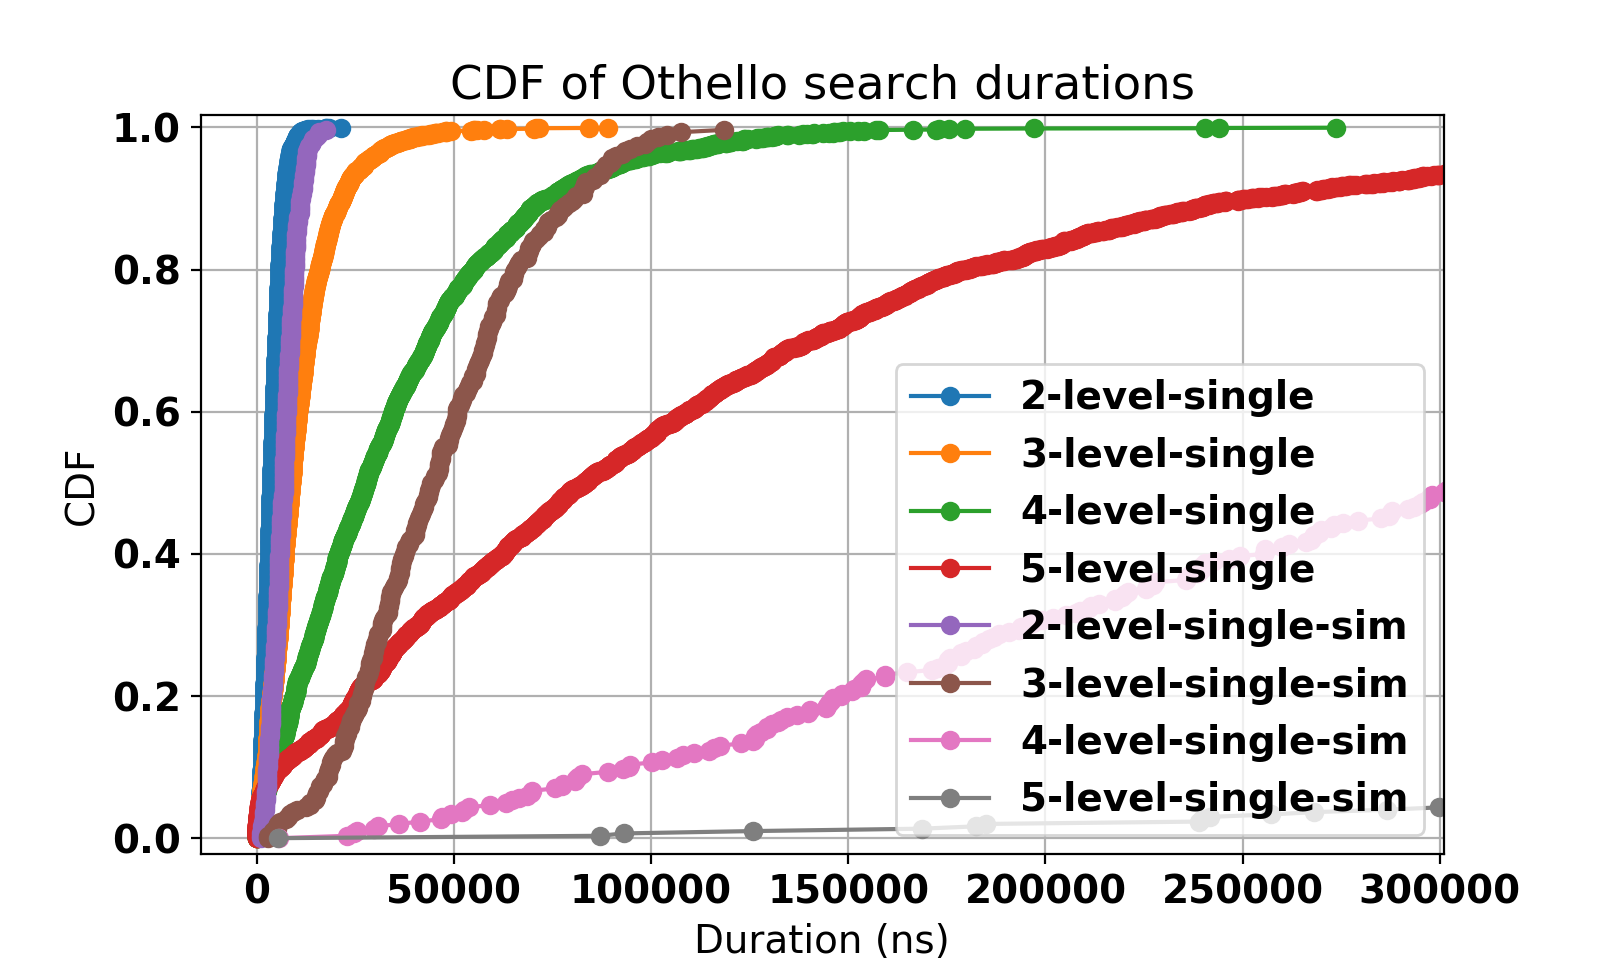

2-level-single Statistics:
	99% = 10745.79
	50% = 3850.0
3-level-single Statistics:
	99% = 43025.4
	50% = 8578.0
4-level-single Statistics:
	99% = 135347.16
	50% = 27675.0
5-level-single Statistics:
	99% = 561607.0
	50% = 83217.0
2-level-single-sim Statistics:
	99% = 14914.45
	50% = 6849.5
3-level-single-sim Statistics:
	99% = 101656.89
	50% = 44215.0
4-level-single-sim Statistics:
	99% = 718161.99
	50% = 304387.5
5-level-single-sim Statistics:
	99% = 4859294.24
	50% = 1951987.0


In [16]:
from plot_stats import plot_search_cdf

plot_search_cdf('data/1000H-completion-times/2-level-single.csv',
                'data/1000H-completion-times/3-level-single.csv',
                'data/1000H-completion-times/4-level-single.csv',
                'data/1000H-completion-times/5-level-single.csv',
                'data/1000H-completion-times/2-level-single-sim.csv',
                'data/1000H-completion-times/3-level-single-sim.csv',
                'data/1000H-completion-times/4-level-single-sim.csv',
                'data/1000H-completion-times/5-level-single-sim.csv')
#                'data/1000H-completion-times/2-level-distributed.csv',
#                'data/1000H-completion-times/3-level-distributed.csv',
#                'data/1000H-completion-times/4-level-distributed.csv',
#                'data/1000H-completion-times/5-level-distributed.csv',
#                'data/1000H-completion-times/6-level-distributed.csv')